In [1]:
import osOps  # see github.com/romstroller/FileTools
import dUtils as utls

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import nltk
import os

## Gender in a million headlines

***
### OBJECTIVE

This report examines the comparative prominence of different genders in the 
main subject matter of news communications - specifically, how the balance of 
coverage between male and female individuals or groups, by frequency of words 
in a headline ("headwords"), has changed through time. Analysis is limited to 
headlines from the Australian national broadcaster (the ABC). The aim is to 
establish the scope and support for editorial policy changes which enable a 
more representative distribution of gender in media, if an imbalance is found 
to exist.

**STAKEHOLDERS:**

**OUTCOME:**

### DATA acquisition, cleaning and feature engineering

In [2]:
dfOR = osOps.OsKit().getKaggleSet( 'therohk', 'million-headlines' )

- [221018_202237029200] Got 'million-headlines.zip'
                        dated='2022_08_30_13_12_02_078157'


In [3]:
print( f"- n articles: {dfOR.shape[0]}" )
print( f"- av. art/mo: {dfOR.groupby('publish_date').count().mean()[0]:.2f}" )
print( f"- begin date: {(dfDat := sorted(dfOR.publish_date.to_list()))[0]}" )
print( f"- until date: {dfDat[-1]}" )

- n articles: 1244184
- av. art/mo: 180.79
- begin date: 20030219
- until date: 20211231


The dataset comprises around 1.25 headlines dated from February 2003 and 
December 2021, averaging 180 per day.

In order to analyse gender-reference frequency, or the number of times 
particular gender pronouns are used in a given day, each headline is to be 
split on each word, retaining the date indexation for each word.

In [4]:
# split headlines into word-by-date
df = pd.DataFrame( dfOR.headline_text.str.split( ' ' ).tolist(),
    index=dfOR.publish_date ).stack().reset_index( inplace=False )
df.rename( columns={ 0: 'word', 'publish_date': 'date' }, inplace=True )
del df[ 'level_1' ]
df

,date,word
0,20030219,aba
1,20030219,decides
2,20030219,against
3,20030219,community
4,20030219,broadcasting
...,...,...
8158762,20211231,here
8158763,20211231,are
8158764,20211231,the
8158765,20211231,new


#### Dimensionality and noise reduction
The general distribution of headword frequency contains a lot of noise from 
words which perform only a syntactical function - "stopwords", usually 
nonsubstantive prepositions and conjunctions like "a", "and", "the", which 
appear among maxima in frequency counts because they are required for common 
construction. For this analysis, where a stopword is not itself a gender 
pronoun, it can be excluded from the dataset as a processing convenience.     

#### Gender keywords
Gendered individuals as objects of communication, in a set where non-gendered 
stopwords are omitted) be estimated to occur:

- **Variant one**: for males, equally with "man" and "men", and for 
females, likewise with "woman" and "women".

- **Variant two (extended)**:
 - Include "male", "males", "man", "men, "female", "females", "woman", "women"
 - "for males, equally for occurances of "he", "him", "his", "himself" ( and 
common syntactical variations like "he's" and "he'd" ) and equivalently for 
females with "she", "her", "hers", "herself"."
 - "boys", "boy", "girl", "girls"?

#### Get count omitting stopwords

In [5]:
# get and omit non-gen stopwords, run counter
nltk.download( 'stopwords', download_dir=os.getcwd() )
with open( "corpora\stopwords\english", 'r' ) as f:
    stopwords = [ line.strip() for line in f ]
m, f = [ "man", "men" ], ["woman", "women" ]
# EXTENDED
# m = [ "male", "males", "man", "men", "he", "him", "his", "himself"  ]
# f = [ "female", "females", "woman", "women", "she", "her", "hers", "herself" ]
stopwordsV1 = [ w for w in stopwords if w not in m + f ]
dfNonStopV1 = df[ ~df[ 'word' ].isin( stopwordsV1 ) ]
wordcount = Counter( dfNonStopV1[ 'word' ].tolist() )
mostComm = wordcount.most_common()
for w in mostComm[ :25 ]: print( w )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romstroller\PYC\millionHeadlines...
[nltk_data]   Package stopwords is already up-to-date!


('police', 39813)
('new', 33729)
('man', 30627)
('says', 23731)
('us', 20370)
('court', 18180)
('govt', 17091)
('australia', 17071)
('council', 16955)
('nsw', 16516)
('fire', 15512)
('interview', 15426)
('australian', 13632)
('wa', 13464)
('sydney', 13065)
('plan', 12993)
('water', 12850)
('death', 12749)
('qld', 12590)
('crash', 12356)
('health', 11967)
('back', 11221)
('charged', 11193)
('murder', 10529)
('report', 10413)


***

###  ANALYSIS, Interpretation and Visualisation

#### Initial observations

A glaring insight for our objective is already available at this point:
*man* is the third-most common word altogether, gendered or otherwise, in 
this cleaned dataset, while none of our female headwords are even in the 
top 25. How are the female headwords ranked?

In [6]:
for c in [
    f"rank {i + 1}: {x[ 0 ]} (count {x[ 1 ]})" for i, x in enumerate( mostComm )
    if x[ 0 ] in [ "man", "men", "woman", "women" ] ]:
    print( c )

rank 3: man (count 30627)
rank 37: woman (count 9463)
rank 246: women (count 3867)
rank 321: men (count 3160)


"Woman" doesn't get in the ranking until 37th, over three times less-frequently 
than "man". Interestingly, "women" then appears at 246th, some ways above "men" 
at 321st. In the simplistic limitations of our analysis, if a group of gendered 
people is of concern, it is more likely to be of women, while if a gendered 
individual is of concern, it is more likely to be a man.

To clearly present the shifting balance of gendered headwords through time, 
the count of male versus female headwords from the beginning to end date of the 
dataset is collected by month and plotted in overlay.

In [7]:
# produce dfs grouping monthly counts for each gender headword set 
genDfs = [ ]
for t, gdr in { 'men': [ "man", "men" ], 'wom': [ "woman", "women" ] }.items():
    gDf = pd.concat( [
        dfNonStopV1[ dfNonStopV1.word == gdr[ 0 ] ],
        dfNonStopV1[ dfNonStopV1.word == gdr[ 1 ] ]
        ], axis=0 ).sort_values( by=[ 'date' ], ascending=True )
    gDf[ 'date' ] = gDf[ 'date' ].astype( str ).str[ :6 ]  # by month
    gDf = gDf.groupby( 'date' ).size().reset_index( name=f'{t}Count' )
    genDfs.append( gDf )

merged = pd.merge( genDfs[ 0 ], genDfs[ 1 ], on='date' ).set_index( 'date' )
merged.reset_index( inplace=True )
df = merged.sort_values( by='date', ascending=True ).astype( int )

df

,date,menCount,womCount
0,200302,74,17
1,200303,159,51
2,200304,146,40
3,200305,164,49
4,200306,158,42
...,...,...,...
222,202108,10,11
223,202109,4,10
224,202110,9,9
225,202111,23,7


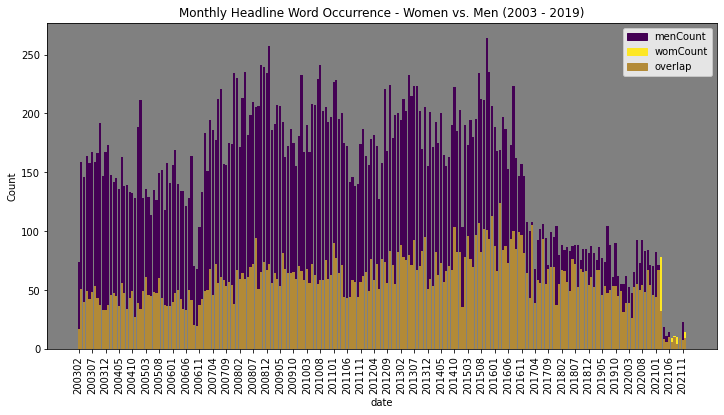

In [42]:
def plotOverlapping( _df, _xFt, _y1ft, _y2ft, yLab, figsiz, title = "" ):
    
    plt.figure( figsize=figsiz, facecolor="white", )
    
    x = _df[ _xFt ]
    xpos = [ i for i, _ in enumerate( x ) ]
    
    cols = { _y1ft: '#440154', _y2ft: '#fde725', 'overlap': "#b38b38" }
    
    plt.bar( xpos, _df[ _y2ft ], color=cols[ _y2ft ] )
    plt.bar( xpos, _df[ _y1ft ], color=cols[ _y1ft ] )
    plt.bar( xpos, _df[ _y2ft ], color=cols[ _y2ft ], alpha=0.6 )
    ax1 = plt.gca()
    ax1.set_facecolor( '#808080' )
    
    plt.xlabel( _xFt )
    plt.ylabel( yLab )
    plt.title( title )
    plt.xticks( xpos, x )
    plt.xticks( rotation=90 )
    ax1.locator_params( nbins=50, axis='x' )
    
    labs = list( cols.keys() )
    plt.legend( [ plt.Rectangle( (0, 0), 1, 1, color=cols[ lb ] )
        for lb in labs ], labs )
    
    plt.savefig( f'ghp_full{osOps.OsKit().dtStamp()}.png', bbox_inches='tight' )
    plt.show()

plotOverlapping( df, 'date', 'menCount', 'womCount', "Count", (12, 6),
    title="Monthly Headline Word Occurrence - Women vs. Men (2003 - 2019)" )

In [50]:
firstParity = df.loc[ df[ 'womCount' ] >= df[ 'menCount' ], 'date' ].iloc[ 0 ]

# Focus on segment where womCount equals or exceeds menCount
dfParity = df[ df[ 'date' ] > firstParity - 3 ]

# average wom % men pre and post 201611, and all-time
df["womPercMen"] = df.womCount / df.menCount
wpmAll = df.womPercMen.mean()
dfPre201611 =  df[ df[ 'date' ] < 201611 ].copy()
dfPre201611["womPercMen"] = dfPre201611.womCount / dfPre201611.menCount
wpmPre201611 = dfPre201611.womPercMen.mean()
dfPos201611 =  df[ df[ 'date' ] >= 201611 ].copy()
dfPos201611["womPercMen"] = dfPos201611.womCount / dfPos201611.menCount
wpmPos201611 = dfPos201611.womPercMen.mean()

utls.write( { 
    "First Parity" : firstParity,
    "Wom % Mal Fr" : f"{wpmAll:.2f}",
    "W%M pre-1611" : f"{wpmPre201611:.2f}",
    "W%M pos-1611" : f"{wpmPos201611:.2f}"
    }, 
    bullets = True )

- First Parity    202103
 - Wom % Mal Fr    0.46
 - W%M pre-1611    0.35
 - W%M pos-1611    0.77

- Male pronouns used far more often than female (female is 0.46 
the average frequency of male)
- Mostly (until end 2017), female pronouns are mentioned on average 
0.35 the frequency of male pronouns
- Female pronoun mentions then rise rapidly to average 0.77 the male amount
- This convergence is the result of the words "men" and "man" being used less, 
rather than "woman" and "women" being used more
- Absolute parity is nearly reached in March 2017, possibly due to 
International Women's Day on the 8th.
- Parity is reached (exceeded) in March 2021 and several times afterward

Taking a closer look at the segment where parity is reached and exceeded - 
exceeded at first quite dramatically, at over twice the male frequency:

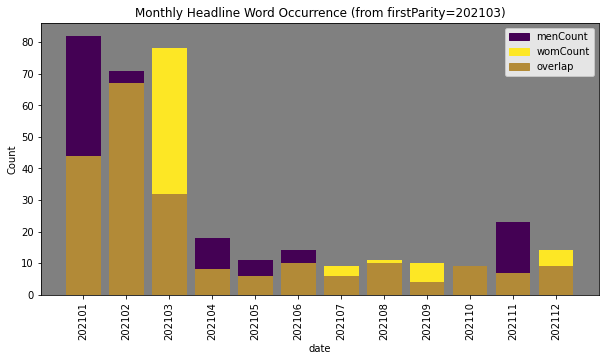

In [45]:
plotOverlapping( dfParity, 'date', 'menCount', 'womCount', "Count", (10, 5),
    title=f"Monthly Headline Word Occurrence (from {firstParity=})" )

#### Summary interpretations

The public concern for stories dominated by either gender 
in particular as drawn significantly close to parity in recent years, while 
women remain consistently less in-focus than men.**